In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display

from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm, notebook,trange
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score as acc_score
from sklearn.metrics import recall_score as rec_score
from sklearn.metrics import precision_score as prec_score
from sklearn.metrics import f1_score as f_scores
from sklearn.metrics import confusion_matrix 

In [3]:
from keras import backend as K
from keras.applications import ResNet50,VGG19,VGG16,Xception,InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Flatten,BatchNormalization
from keras.layers import Dense,Dropout
from keras.optimizers import Adam
import plotly as px
import plotly.graph_objects as go

2024-10-07 09:38:34.711325: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-07 09:38:34.881117: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-07 09:38:35.546603: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
from pylab import rcParams
rcParams['figure.figsize'] = 15,6
plt.style.use('fivethirtyeight')

import warnings 
warnings.filterwarnings(action="ignore")

In [5]:
train_data = pd.read_csv("cv-valid-train.csv")

In [6]:
train_data.head()

,filename,text,up_votes,down_votes,age,gender,accent,duration
0,cv-valid-train/sample-000000.mp3,learn to recognize omens and follow them the o...,1,0,NaN,NaN,NaN,NaN
1,cv-valid-train/sample-000001.mp3,everything in the universe evolved he said,1,0,NaN,NaN,NaN,NaN
2,cv-valid-train/sample-000002.mp3,you came so that you could learn about your dr...,1,0,NaN,NaN,NaN,NaN
3,cv-valid-train/sample-000003.mp3,so now i fear nothing because it was those ome...,1,0,NaN,NaN,NaN,NaN
4,cv-valid-train/sample-000004.mp3,if you start your emails with greetings let me...,3,2,NaN,NaN,NaN,NaN


In [7]:
train_data = train_data[["filename","age","gender","accent"]]

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195776 entries, 0 to 195775
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   filename  195776 non-null  object
 1   age       73768 non-null   object
 2   gender    74059 non-null   object
 3   accent    64711 non-null   object
dtypes: object(4)
memory usage: 6.0+ MB


In [9]:
train_data.dropna(inplace=True)
train_data.reset_index(inplace=True)
train_data.drop("index",axis=1,inplace=True)

In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63163 entries, 0 to 63162
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  63163 non-null  object
 1   age       63163 non-null  object
 2   gender    63163 non-null  object
 3   accent    63163 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


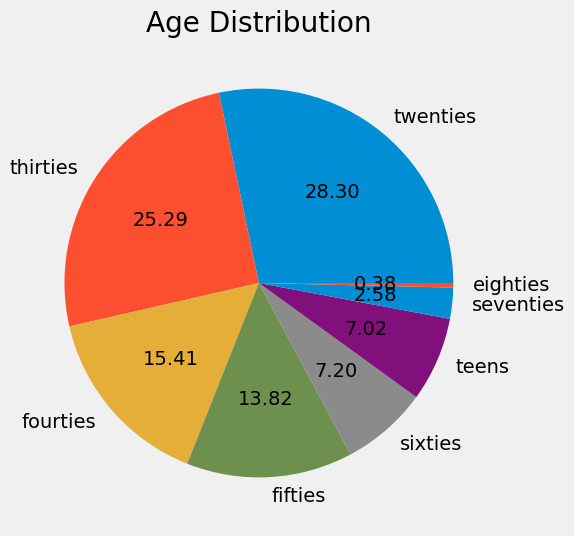

In [11]:
plt.title("Age Distribution")
plt.pie(train_data.age.value_counts().values,labels=train_data.age.value_counts().index,autopct="%0.2f")
plt.show()

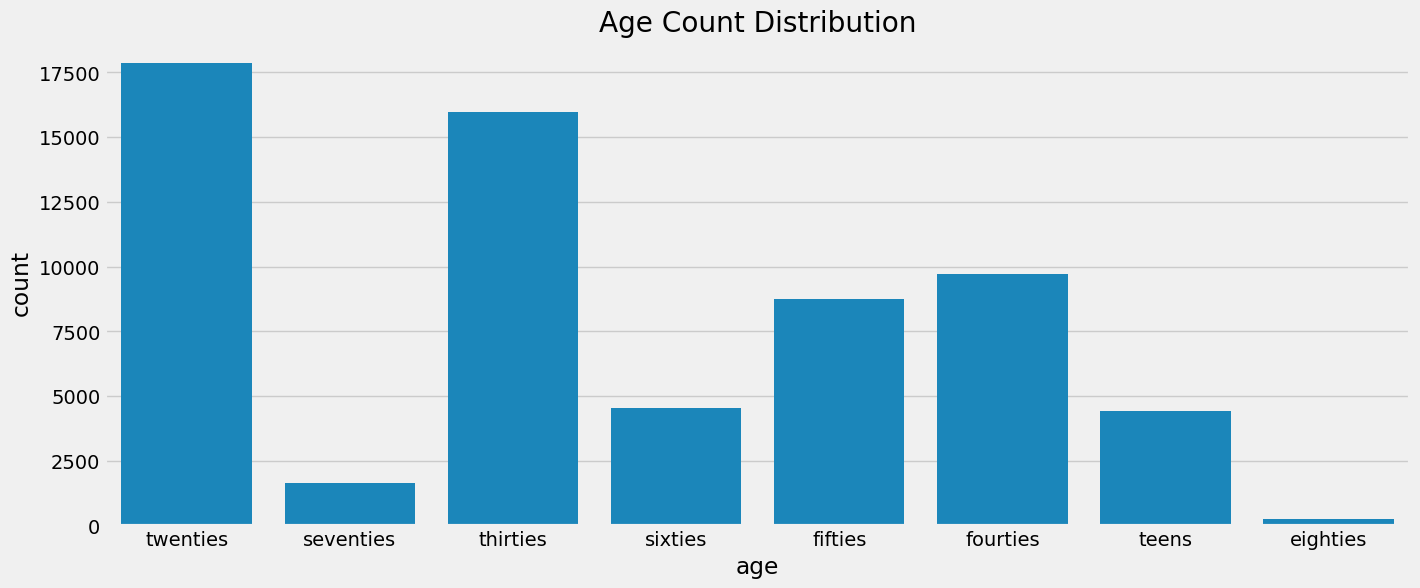

In [12]:
plt.title("Age Count Distribution")
sns.countplot(x=train_data.age)
plt.show()

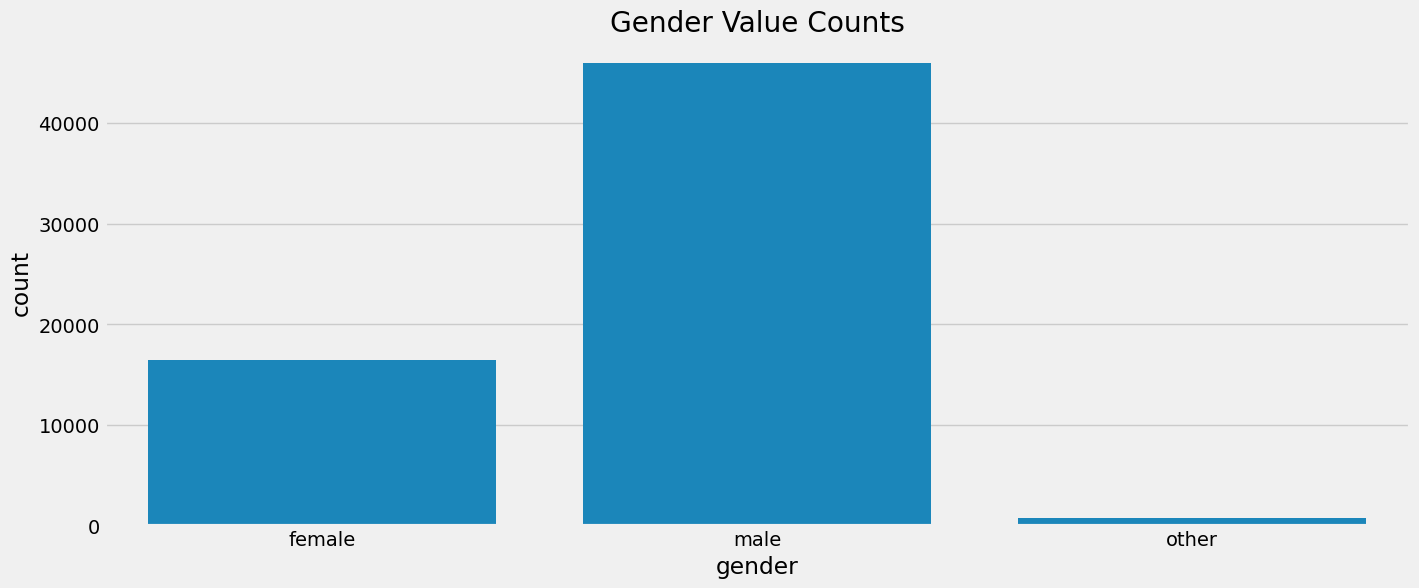

In [13]:
plt.title("Gender Value Counts")
sns.countplot(x=train_data.gender)
plt.show()

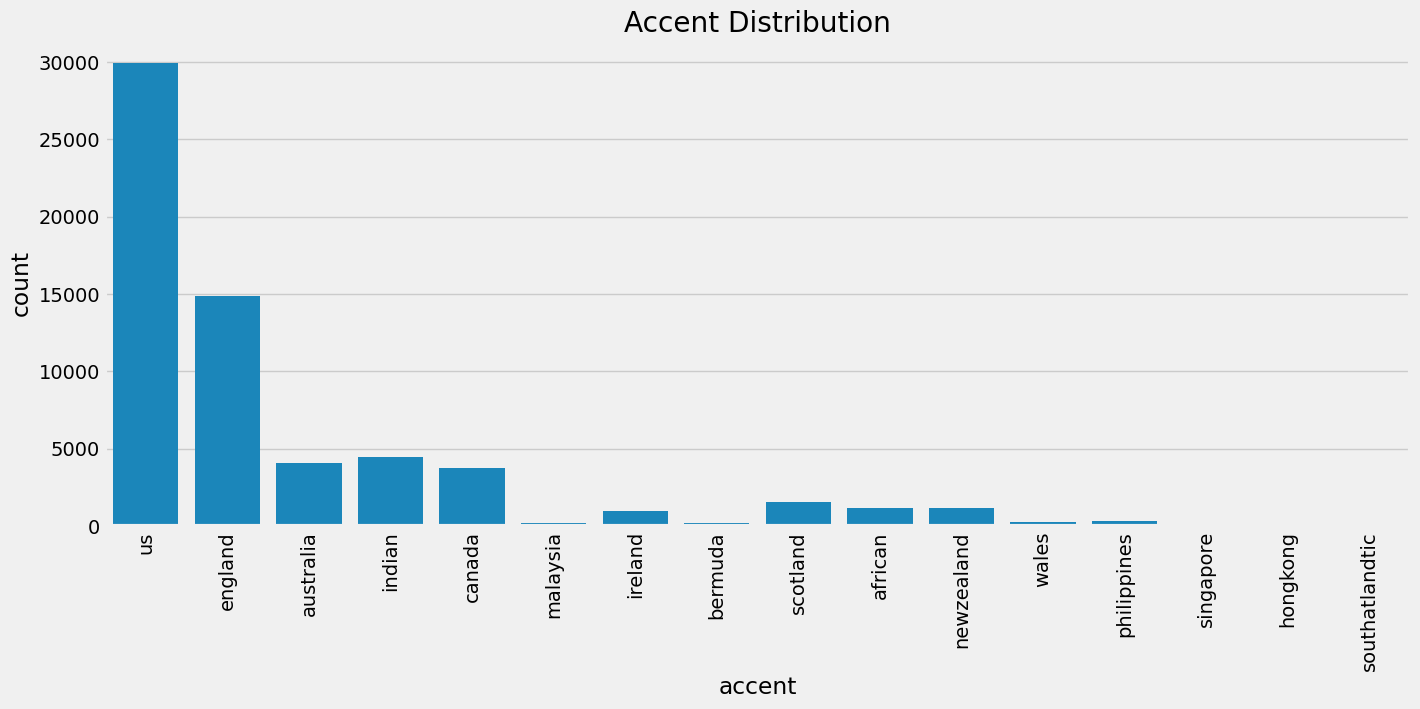

In [14]:
plt.title("Accent Distribution")
sns.countplot(x=train_data.accent)
plt.xticks(rotation=90)
plt.show()

In [15]:
accent_to_keep = train_data.accent.value_counts().index[0:9]

idx = []
for i in range(train_data.shape[0]):
    if train_data.accent[i] in accent_to_keep:
        idx.append(i)

In [16]:
train_data = train_data.loc[idx]
train_data.reset_index(inplace=True)
train_data.drop("index",axis=1,inplace=True)

Visualizing some features of Audio wave

In [17]:
voice_dir = "cv-valid-train-extracted"
sample_rate = 16000

In [18]:
# Taking Random voice sample
idx = np.random.randint(0,len(train_data))
# storing idx'th voice fiel name
filename = voice_dir +"/"+train_data.filename[idx]

<Figure size 1200x300 with 0 Axes>

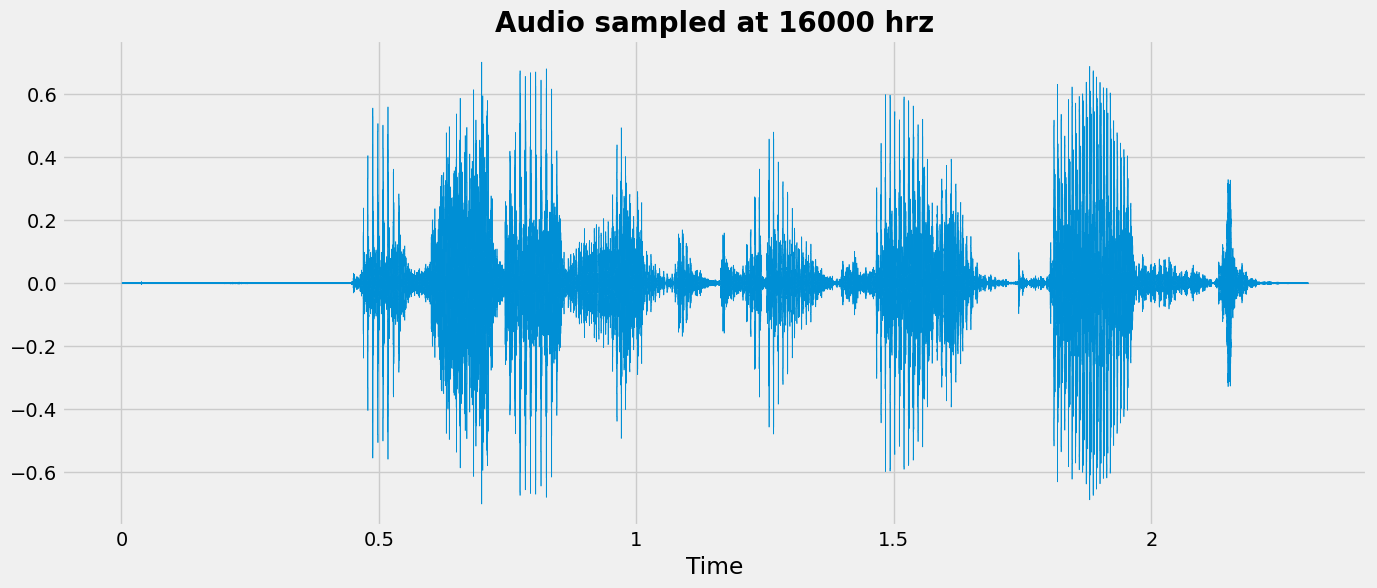

In [20]:
# Loading audio sample
audio_array, sampling_rate = librosa.load(filename, sr=sample_rate)
# Creating figure
plt.figure(figsize=(12, 3))
plt.figure()
librosa.display.waveshow(audio_array, sr=sampling_rate)
plt.title('Audio sampled at {} hrz'.format(sample_rate),fontsize = 20, loc='center', fontdict=dict(weight='bold'))
plt.show()

Mel-Frequency Cepstral Coefficient

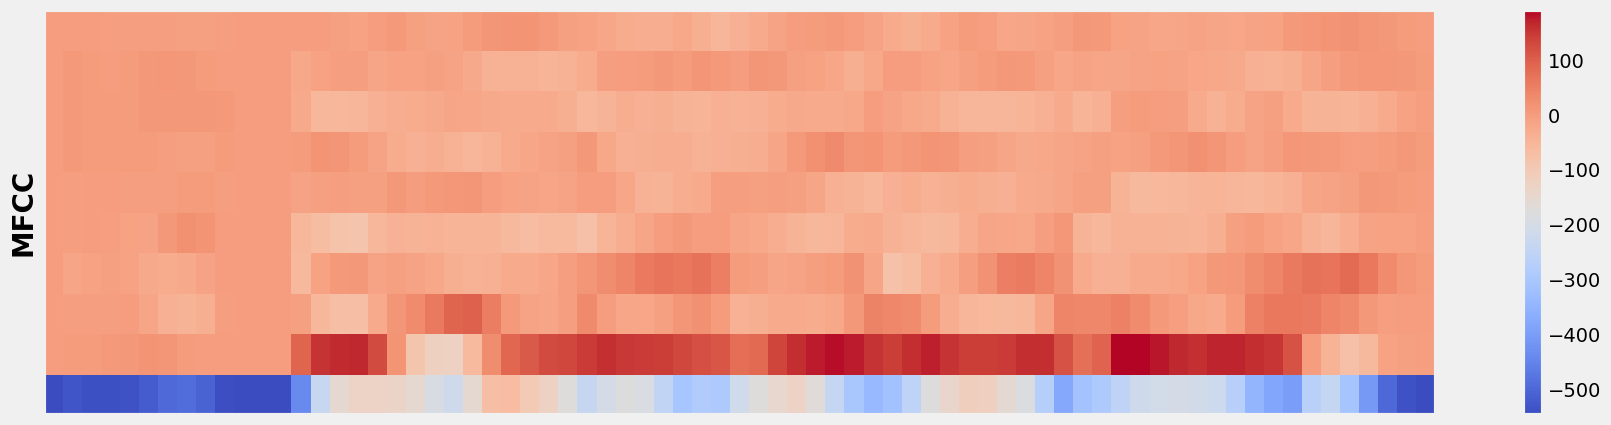

In [21]:
# Loading Audio sample
audio_array,sampling_rate = librosa.load(filename, sr=sample_rate) 
# MFCC with 10 components
mfcc = librosa.feature.mfcc(y=audio_array, sr=sample_rate, n_mfcc = 10) 

plt.figure(figsize=(20,5))
librosa.display.specshow(mfcc)
plt.ylabel('MFCC',fontsize = 20, loc='center', fontdict=dict(weight='bold'))
plt.colorbar()
plt.show()

Log Mel-spectogram

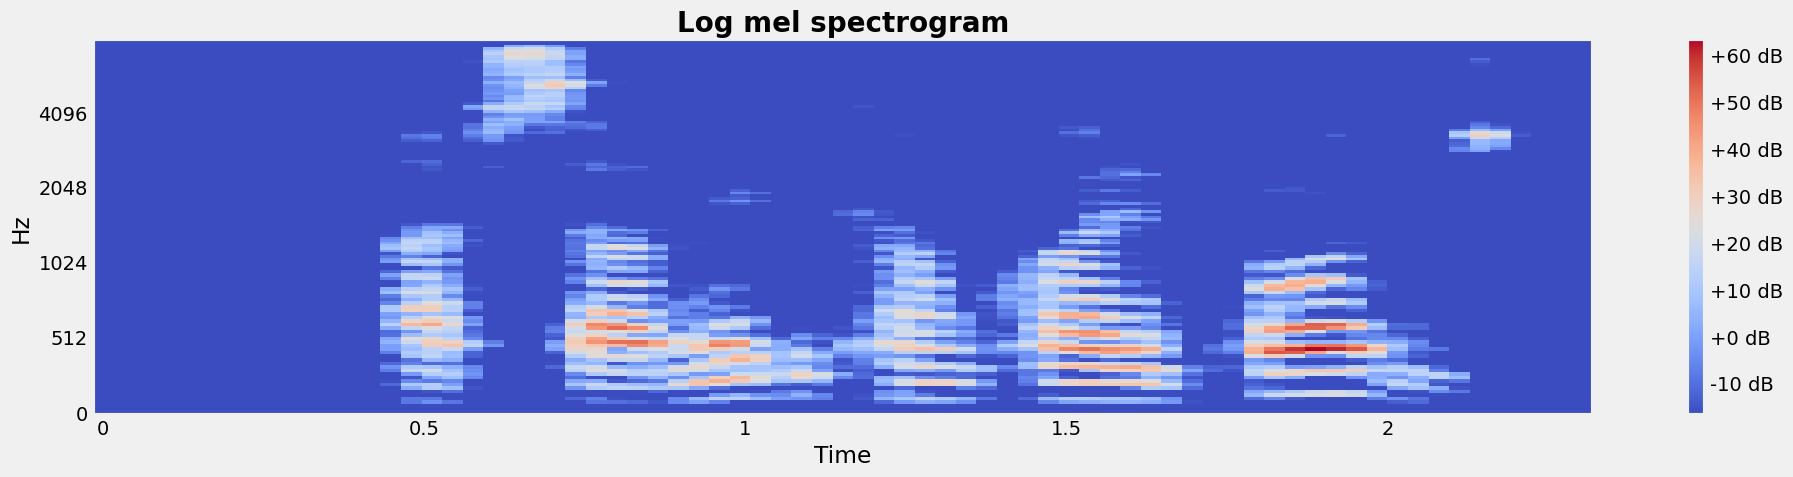

In [22]:
audio_array, sampling_rate = librosa.load(filename, sr=sample_rate) 
mel_spectogram = librosa.feature.melspectrogram(y=audio_array, sr=sampling_rate, n_mels=128,fmax=8000)

# Convert to log scale
log_S = librosa.amplitude_to_db(mel_spectogram)

# Plotting Log Mel-Spectogram
plt.figure(figsize=(20,5))
librosa.display.specshow(log_S, sr=sampling_rate, x_axis='time', y_axis='mel')
plt.title('Log mel spectrogram',fontsize = 20, loc='center', fontdict=dict(weight='bold'))
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

Chroma

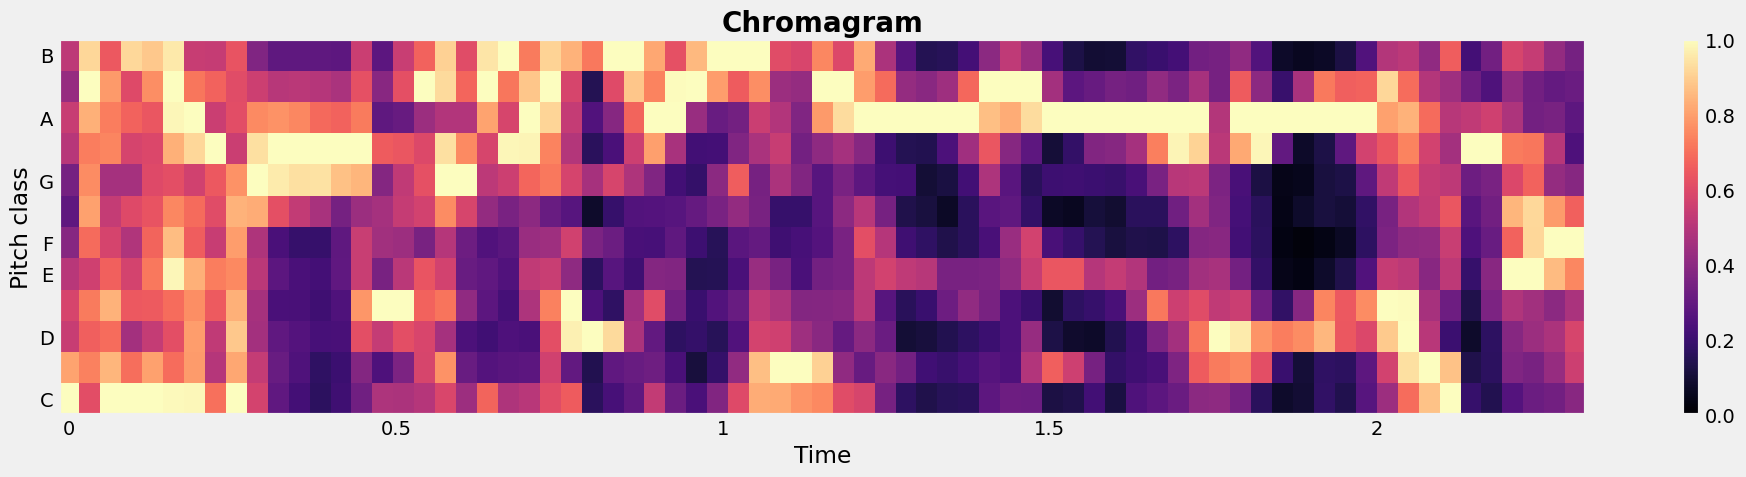

In [23]:
audio_array, sampling_rate = librosa.load(filename, sr=sample_rate)
chroma = librosa.feature.chroma_cqt(y=audio_array, sr=sampling_rate)


plt.figure(figsize=(20,5))

librosa.display.specshow(chroma, sr=sampling_rate, x_axis='time', y_axis='chroma', vmin=0, vmax=1)
plt.title('Chromagram',fontsize = 20, loc='center', fontdict=dict(weight='bold'))
plt.colorbar()
plt.tight_layout()

Audio Preprocessing

In [24]:
scaler = MinMaxScaler()

In [25]:
# making Directories to store processed data
os.mkdir("./age_data")
os.mkdir("./gender_data")
os.mkdir("./accent_data")

In [26]:
def process_data(file,target_dir):  
    filename = voice_dir +  "/" + file
    y, s = librosa.load(filename, sr=16000)
    y_filt = librosa.effects.preemphasis(y)
    S_preemph = librosa.amplitude_to_db(np.abs(librosa.stft(y_filt)), ref=np.max)
    S_preemph = scaler.fit_transform(S_preemph)
    #librosa.display.specshow(S_preemph, y_axis='log', x_axis='time')
    plt.imshow(S_preemph.T,cmap='plasma')
    plt.axis("off")
    file = file.split("/")[1]
    address = target_dir+"/"+"{}.png".format(file)
    plt.savefig(address)
    plt.close()

Stroing Gender data

In [27]:
idx = []
cnt_male,cnt_female = 0,0
num_samples = 500
for i in range(train_data.shape[0]):
    if train_data.gender[i] == "male":
        if cnt_male <= num_samples:
            cnt_male +=1
            idx.append(i)
    
    if train_data.gender[i] == "female":
        if cnt_female <= num_samples:
            cnt_female +=1
            idx.append(i)
train_data_gender = train_data.loc[idx]
train_data_gender.reset_index(inplace=True)
train_data_gender.drop("index",axis=1,inplace=True)

In [28]:
for idx in trange(train_data_gender.shape[0]):
    file,gender_group = train_data_gender.filename[idx],train_data_gender.gender[idx]
    path = './gender_data'+"/"+gender_group
    if os.path.isdir(path):
        process_data(file,path)
    else :
        os.mkdir(path)
        process_data(file,path)

100%|███████████████████████████████████████| 1002/1002 [01:34<00:00, 10.62it/s]


Storing Age Data¶

In [29]:

import numpy as np
import pandas as pd
import os
import librosa

# Assume train_data is already loaded
voice_dir = 'cv-valid-train-extracted'  # Adjust the path if necessary

# Sample counter and limit
cnt_teens = 0
num_samples = 5  # Number of samples you want to process

# Process samples
for idx in range(len(train_data)):
    if cnt_teens < num_samples:
        filename = os.path.join(voice_dir, train_data.filename[idx])
        print(f"Selected filename: {filename}")

        # Load the audio file
        audio_array, sampling_rate = librosa.load(filename, sr=None)
        print(f"Loaded audio with shape: {audio_array.shape}, Sample Rate: {sampling_rate}")

        # Increment counter for samples processed
        cnt_teens += 1
    else:
        break  # Exit the loop after processing the required number of samples


Selected filename: cv-valid-train-extracted/cv-valid-train/sample-000005.mp3
Loaded audio with shape: (279936,), Sample Rate: 48000
Selected filename: cv-valid-train-extracted/cv-valid-train/sample-000008.mp3
Loaded audio with shape: (82944,), Sample Rate: 48000
Selected filename: cv-valid-train-extracted/cv-valid-train/sample-000013.mp3
Loaded audio with shape: (202752,), Sample Rate: 48000
Selected filename: cv-valid-train-extracted/cv-valid-train/sample-000014.mp3
Loaded audio with shape: (258048,), Sample Rate: 48000
Selected filename: cv-valid-train-extracted/cv-valid-train/sample-000019.mp3
Loaded audio with shape: (178560,), Sample Rate: 48000


In [30]:
num_samples = 500
idx = []
cnt_teens,cnt_twenties,cnt_thirties,cnt_fourties,cnt_fifties,cnt_sixties,cnt_seventies = 0,0,0,0,0,0,0
for i in range(train_data.shape[0]):
    if train_data.age[i] == "twenties":
        if cnt_twenties <= num_samples:
            cnt_twenties +=1
            idx.append(i)
    
    if train_data.age[i] == "thirties":
        if cnt_thirties <= num_samples:
            cnt_thirties +=1
            idx.append(i)
    if train_data.age[i] == "fourties":
        if cnt_fourties <= num_samples:
            cnt_fourties +=1
            idx.append(i)
    if train_data.age[i] == "fifties":
        if cnt_fifties <= num_samples:
            cnt_fifties +=1
            idx.append(i)
    if train_data.age[i] == "sixties":
        if cnt_sixties <= num_samples:
            cnt_sixties +=1
            idx.append(i)
    if train_data.age[i] == "seventies":
        if cnt_seventies <= num_samples:
            cnt_seventies +=1
            idx.append(i)
    if train_data.age[i] == "teens":
        if cnt_teens <= num_samples:
            cnt_teens +=1
            idx.append(i)
train_data_age = train_data.loc[idx]
train_data_age.reset_index(inplace=True)
train_data_age.drop("index",axis=1,inplace=True)

In [31]:
for idx in trange(train_data_age.shape[0]):
    file,age_group = train_data_age.filename[idx],train_data_age.age[idx]
    path = './age_data'+"/"+age_group
    if os.path.isdir(path):
        process_data(file,path)
    else :
        os.mkdir(path)
        process_data(file,path)

100%|███████████████████████████████████████| 3507/3507 [05:36<00:00, 10.41it/s]


Storing Accent data

In [32]:
num_samples = 200
idx = []
cnt_dict = {"us":0,"england":0,"indian":0,"australia":0,"canada":0,
 "scotland":0,"newzealand":0,"african":0,"ireland":0 }
for i in range(train_data.shape[0]):
    if cnt_dict[train_data.accent[i]] <= num_samples:
        cnt_dict[train_data.accent[i]] +=1
        idx.append(i)
    
    
train_data_accent = train_data.loc[idx]
train_data_accent.reset_index(inplace=True)
train_data_accent.drop("index",axis=1,inplace=True)

In [33]:
for idx in trange(train_data_accent.shape[0]):
    file,accent_group = train_data_accent.filename[idx],train_data_age.accent[idx]
    path = './accent_data'+"/"+accent_group
    if os.path.isdir(path):
        process_data(file,path)
    else :
        os.mkdir(path)
        process_data(file,path)

100%|███████████████████████████████████████| 1809/1809 [02:50<00:00, 10.59it/s]


Defining models

In [34]:
def preprocessFn(img):
    return (img-127.0)/127.0

In [35]:
depth = 3
INIT_LR = 0.001
EPOCHS = 10
inputShape=(128,128,3)

data_gen = ImageDataGenerator(validation_split=0.2,preprocessing_function=preprocessFn)

In [36]:
def recall_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def spec_sens(confusion_matrix):
    FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
    FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
    TP = np.diag(confusion_matrix)
    TN = confusion_matrix.sum() - (FP + FN + TP)

    # Sensitivity, hit rate, recall, or true positive rate
    sensitivity = TP/(TP+FN)
    # Specificity or true negative rate
    specificity = TN/(TN+FP) 
    
    return sensitivity,specificity

Dense Architechture

In [37]:
def dense_model(base_model,num_classes):
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

In [38]:
def define_models(classes):
    num_class = classes
    #Xception
    model_xcep = Xception(include_top=False, weights="imagenet",input_shape =inputShape)
    model_xception = dense_model(model_xcep,num_class)
    model_xception.layers[0].trainable = False

    # InceptionV3
    model_incep = InceptionV3(include_top=False, weights="imagenet",input_shape =inputShape)
    model_inception = dense_model(model_incep,num_class)
    model_inception.layers[0].trainable = False

    #VGG16
    model_1 = VGG16(include_top=False, weights="imagenet",input_shape =inputShape)
    model_vgg1 = dense_model(model_1,num_class)
    model_vgg1.layers[0].trainable = False

    #VGG 19
    model_2 = VGG19(include_top=False, weights="imagenet",input_shape =inputShape)
    model_vgg2 = dense_model(model_2,num_class)
    model_vgg2.layers[0].trainable = False

    #ResNet50
    model_res = ResNet50(include_top=False, weights="imagenet",input_shape =inputShape)
    model_resnet = dense_model(model_res,num_class)
    model_resnet.layers[0].trainable = False

    return [model_xception,model_inception,model_vgg1,model_vgg2,model_resnet]

Ensemble

In [39]:
def stacking_predictions(models,data):
    # array to store values
    stackValues = None
    for model in models:
        # making predictions for each model
        y_pred = model.predict(data)
        # stack predictions into [rows, members, probabilities]
        if stackValues is None:
            stackValues = y_pred
        else:
            stackValues = np.dstack((stackValues,y_pred))
    # flatten predictions to [rows, members x probabilities]
    stackValues = stackValues.reshape((stackValues.shape[0], stackValues.shape[1]*stackValues.shape[2]))
    return stackValues

In [40]:
def fit_models(models,data):
    # stacked data with ensemble
    stackedValues = stacking_predictions(models,data)
    log_reg = LogisticRegression()
    log_reg.fit(stackedValues,data.labels)
    return log_reg

In [41]:
def stacked_prediction(members, model, inputX):
    # create dataset using ensemble
    stackedX = stacking_predictions(members, inputX)
    # make a prediction
    yhat = model.predict(stackedX)
    return yhat

Gender prediction

Found 802 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
[INFO] training sequential_3...
Epoch 1/10
201/201 [==============================] - 37s 85ms/step - loss: 0.8766 - accuracy: 0.5162 - val_loss: 0.6860 - val_accuracy: 0.6100
Epoch 2/10
201/201 [==============================] - 12s 57ms/step - loss: 0.6341 - accuracy: 0.6347 - val_loss: 0.6694 - val_accuracy: 0.7150
Epoch 3/10
201/201 [==============================] - 11s 57ms/step - loss: 0.5886 - accuracy: 0.7070 - val_loss: 7.0608 - val_accuracy: 0.5550
Epoch 4/10
201/201 [==============================] - 11s 57ms/step - loss: 0.4896 - accuracy: 0.7805 - val_loss: 1.4632 - val_accuracy: 0.8400
Epoch 5/10
201/201 [==============================] - 11s 57ms/step - loss: 0.5511 - accuracy: 0.7731 - val_loss: 4.7557 - val_accuracy: 0.7150
Epoch 6/10
201/201 [==============================] - 12s 57ms/step - loss: 0.4451 - accuracy: 0.8367 - val_loss: 0.5678 - val_accuracy: 0.7550
Epoch 7/10
201/201 [==

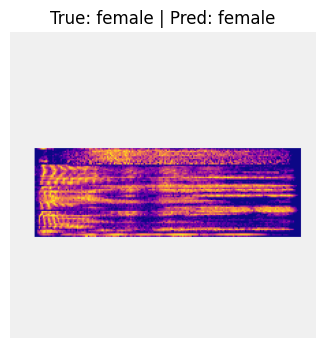

200/200 [==============================] - 3s 12ms/step


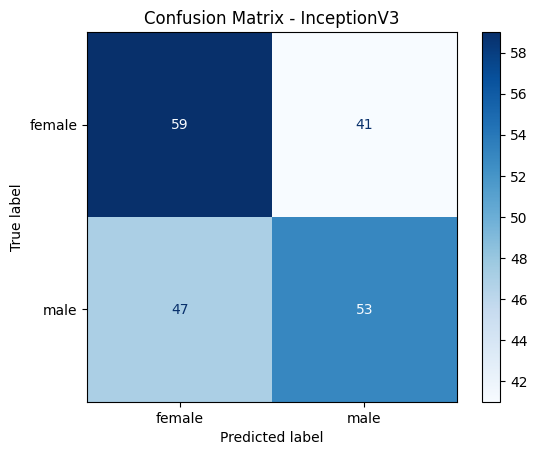

Classification Report - InceptionV3:
               precision    recall  f1-score   support

      female       0.56      0.59      0.57       100
        male       0.56      0.53      0.55       100

    accuracy                           0.56       200
   macro avg       0.56      0.56      0.56       200
weighted avg       0.56      0.56      0.56       200

200/200 [==============================] - 2s 12ms/step


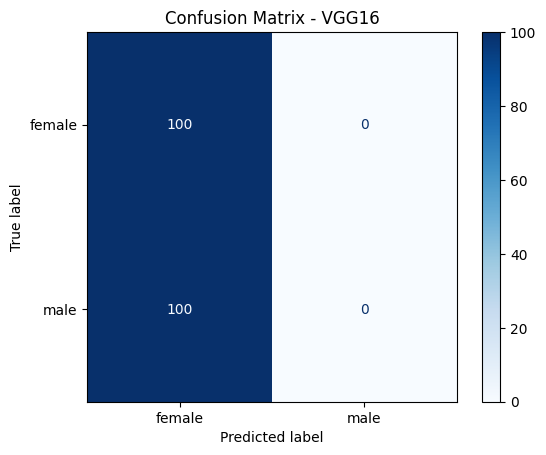

/home/mca/anaconda3/envs/dse/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mca/anaconda3/envs/dse/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mca/anaconda3/envs/dse/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report - VGG16:
               precision    recall  f1-score   support

      female       0.50      1.00      0.67       100
        male       0.00      0.00      0.00       100

    accuracy                           0.50       200
   macro avg       0.25      0.50      0.33       200
weighted avg       0.25      0.50      0.33       200

200/200 [==============================] - 3s 12ms/step


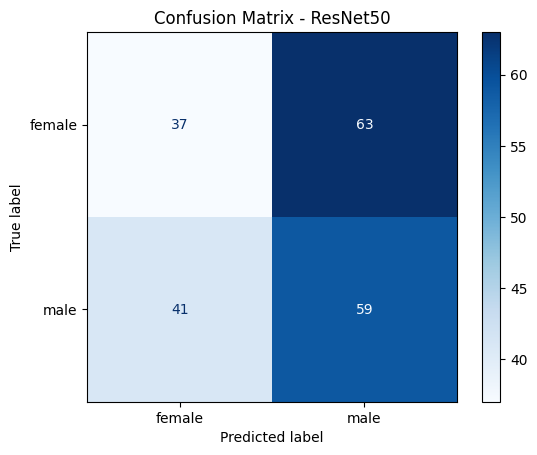

Classification Report - ResNet50:
               precision    recall  f1-score   support

      female       0.47      0.37      0.42       100
        male       0.48      0.59      0.53       100

    accuracy                           0.48       200
   macro avg       0.48      0.48      0.47       200
weighted avg       0.48      0.48      0.47       200



/home/mca/anaconda3/envs/dse/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - 3s 12ms/step - loss: 0.5700 - accuracy: 0.8500
Loaded ResNet model accuracy: 0.85


In [12]:

# Train ResNet50
model_resnet = create_model("resnet")
history_resnet = compile_and_train_model(model_resnet, train_data_gender, val_data_gender)

# Prediction and evaluation functions
def predict_and_display(images, true_labels, model, class_labels):
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)

    plt.figure(figsize=(10, 10))
    for i in range(len(images)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {class_labels[np.argmax(true_labels[i])]} | Pred: {class_labels[predicted_classes[i]]}")
        plt.axis('off')import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.applications import InceptionV3, VGG16, ResNet50
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set your constants
INIT_LR = 0.001
num_classes = 2  # Adjust based on your gender classes (e.g., male/female)
inputShape = (224, 224, 3)  # VGG16 and ResNet require 224x224 input size

# Initialize ImageDataGenerator with validation split for gender data
data_gen_gender = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2  # Split data into training and validation sets
)

# Create training and validation data generators for gender data
train_data_gender = data_gen_gender.flow_from_directory(
    directory=r"./gender_data",
    target_size=inputShape[0:2],
    batch_size=4,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

val_data_gender = data_gen_gender.flow_from_directory(
    directory=r"./gender_data",
    target_size=inputShape[0:2],
    batch_size=1,
    class_mode='categorical',
    shuffle=True,
    subset='validation'
)

# Function to create models
def create_model(model_type):
    if model_type == "inception":
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=inputShape)
    elif model_type == "vgg16":
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=inputShape)
    elif model_type == "resnet":
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=inputShape)
    else:
        raise ValueError("Model type not recognized.")

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Function to compile and train the model
def compile_and_train_model(model, train_data, val_data):
    opt = Adam(learning_rate=INIT_LR)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    
    print(f"[INFO] training {model.name}...")
    history = model.fit(train_data, validation_data=val_data, epochs=10)  # Adjust epochs as needed
    return history

# Train InceptionV3
model_inception = create_model("inception")
history_inception = compile_and_train_model(model_inception, train_data_gender, val_data_gender)

# Train VGG16
model_vgg16 = create_model("vgg16")
history_vgg16 = compile_and_train_model(model_vgg16, train_data_gender, val_data_gender)

    plt.tight_layout()
    plt.show()

# Example for visualizing predictions with InceptionV3
val_images, val_labels = next(iter(val_data_gender))
class_labels = list(train_data_gender.class_indices.keys())
predict_and_display(val_images, val_labels, model_inception, class_labels)

# Confusion Matrix and Classification Report for InceptionV3
val_predictions = model_inception.predict(val_data_gender)
predicted_classes = np.argmax(val_predictions, axis=1)
true_classes = val_data_gender.classes
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - InceptionV3")
plt.show()

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report - InceptionV3:\n", report)

# Now repeat the evaluation for VGG16
val_predictions_vgg16 = model_vgg16.predict(val_data_gender)
predicted_classes_vgg16 = np.argmax(val_predictions_vgg16, axis=1)

# Confusion Matrix and Classification Report for VGG16
cm_vgg16 = confusion_matrix(true_classes, predicted_classes_vgg16)
disp_vgg16 = ConfusionMatrixDisplay(confusion_matrix=cm_vgg16, display_labels=class_labels)
disp_vgg16.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - VGG16")
plt.show()

report_vgg16 = classification_report(true_classes, predicted_classes_vgg16, target_names=class_labels)
print("Classification Report - VGG16:\n", report_vgg16)

# Repeat the evaluation for ResNet50
val_predictions_resnet = model_resnet.predict(val_data_gender)
predicted_classes_resnet = np.argmax(val_predictions_resnet, axis=1)

# Confusion Matrix and Classification Report for ResNet50
cm_resnet = confusion_matrix(true_classes, predicted_classes_resnet)
disp_resnet = ConfusionMatrixDisplay(confusion_matrix=cm_resnet, display_labels=class_labels)
disp_resnet.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - ResNet50")
plt.show()

report_resnet = classification_report(true_classes, predicted_classes_resnet, target_names=class_labels)
print("Classification Report - ResNet50:\n", report_resnet)

# Saving models
model_inception.save("inception_gender_model.h5")
model_vgg16.save("vgg16_gender_model.h5")
model_resnet.save("resnet_gender_model.h5")

# Loading and evaluating the models (Example for ResNet)
loaded_model_resnet = tf.keras.models.load_model("resnet_gender_model.h5")
loss, accuracy = loaded_model_resnet.evaluate(val_data_gender)
print(f"Loaded ResNet model accuracy: {accuracy:.2f}")




Age group prediction

Found 2807 images belonging to 7 classes.
Found 700 images belonging to 7 classes.
[INFO] training InceptionV3 network...
702/702 [==============================] - 57s 59ms/step - loss: 1.9875 - accuracy: 0.1386 - val_loss: 2.5303 - val_accuracy: 0.1457
[INFO] training ResNet network...
702/702 [==============================] - 70s 74ms/step - loss: 1.9881 - accuracy: 0.1404 - val_loss: 1.9460 - val_accuracy: 0.1429
[INFO] training VGG16 network...
702/702 [==============================] - 66s 90ms/step - loss: 1.9736 - accuracy: 0.1361 - val_loss: 1.9461 - val_accuracy: 0.1429
[INFO] InceptionV3 Predictions...
1/1 [==============================] - 1s 574ms/step


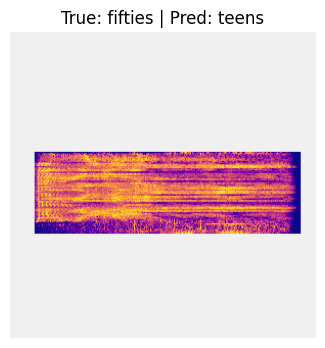

700/700 [==============================] - 10s 13ms/step


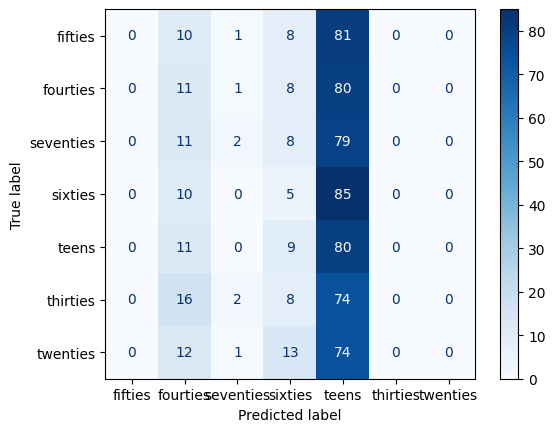

/home/mca/anaconda3/envs/dse/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mca/anaconda3/envs/dse/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mca/anaconda3/envs/dse/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mca/ana

              precision    recall  f1-score   support

     fifties       0.00      0.00      0.00       100
    fourties       0.14      0.11      0.12       100
   seventies       0.29      0.02      0.04       100
     sixties       0.08      0.05      0.06       100
       teens       0.14      0.80      0.25       100
    thirties       0.00      0.00      0.00       100
    twenties       0.00      0.00      0.00       100

    accuracy                           0.14       700
   macro avg       0.09      0.14      0.07       700
weighted avg       0.09      0.14      0.07       700

700/700 [==============================] - 9s 12ms/step - loss: 2.5303 - accuracy: 0.1457
Loaded InceptionV3 model accuracy: 0.15
[INFO] ResNet Predictions...
1/1 [==============================] - 0s 420ms/step


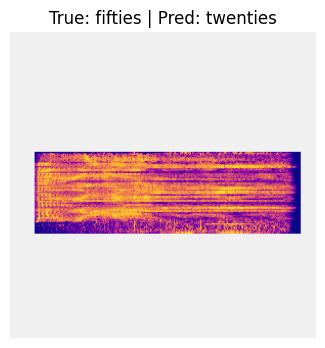

700/700 [==============================] - 9s 12ms/step


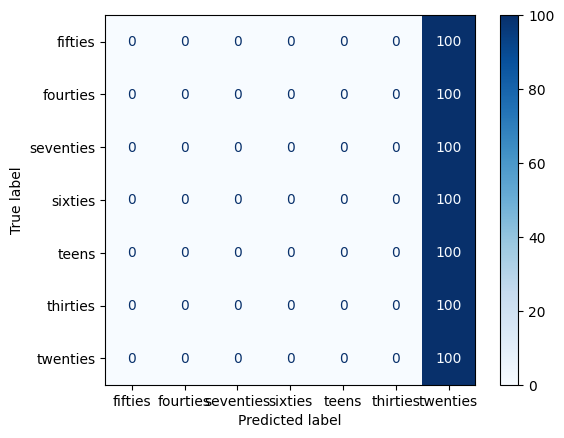

              precision    recall  f1-score   support

     fifties       0.00      0.00      0.00       100
    fourties       0.00      0.00      0.00       100
   seventies       0.00      0.00      0.00       100
     sixties       0.00      0.00      0.00       100
       teens       0.00      0.00      0.00       100
    thirties       0.00      0.00      0.00       100
    twenties       0.14      1.00      0.25       100

    accuracy                           0.14       700
   macro avg       0.02      0.14      0.04       700
weighted avg       0.02      0.14      0.04       700



/home/mca/anaconda3/envs/dse/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mca/anaconda3/envs/dse/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mca/anaconda3/envs/dse/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mca/ana

700/700 [==============================] - 9s 12ms/step - loss: 1.9460 - accuracy: 0.1429
Loaded ResNet model accuracy: 0.14
[INFO] VGG16 Predictions...
1/1 [==============================] - 0s 100ms/step


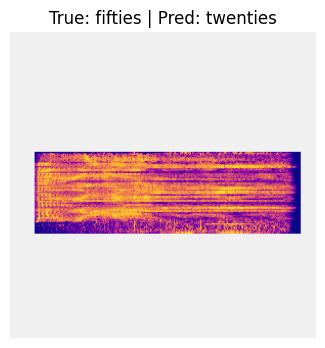

700/700 [==============================] - 9s 12ms/step


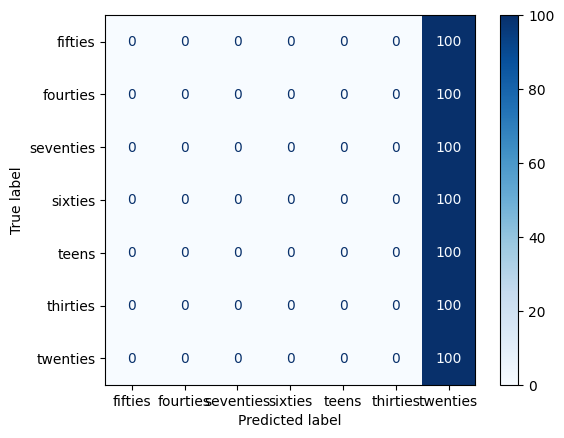

              precision    recall  f1-score   support

     fifties       0.00      0.00      0.00       100
    fourties       0.00      0.00      0.00       100
   seventies       0.00      0.00      0.00       100
     sixties       0.00      0.00      0.00       100
       teens       0.00      0.00      0.00       100
    thirties       0.00      0.00      0.00       100
    twenties       0.14      1.00      0.25       100

    accuracy                           0.14       700
   macro avg       0.02      0.14      0.04       700
weighted avg       0.02      0.14      0.04       700



/home/mca/anaconda3/envs/dse/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mca/anaconda3/envs/dse/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mca/anaconda3/envs/dse/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mca/ana

700/700 [==============================] - 9s 12ms/step - loss: 1.9461 - accuracy: 0.1429
Loaded VGG16 model accuracy: 0.14


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.applications import InceptionV3, ResNet50, VGG16
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set your constants
INIT_LR = 0.001
num_classes = 7
inputShape = (299, 299, 3)

# Initialize ImageDataGenerator
data_gen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)

# Create data generators
train_data = data_gen.flow_from_directory(
    directory=r"./age_data",
    target_size=inputShape[0:2],
    batch_size=4,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

val_data = data_gen.flow_from_directory(
    directory=r"./age_data",
    target_size=inputShape[0:2],
    batch_size=1,
    class_mode='categorical',
    shuffle=True,
    subset='validation'
)

# Function to define and compile a model
def create_model(base_model_class):
    base_model = base_model_class(weights='imagenet', include_top=False, input_shape=inputShape)
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=INIT_LR), metrics=["accuracy"])
    return model

# Train the InceptionV3 model
model_inception = create_model(InceptionV3)
print("[INFO] training InceptionV3 network...")
history_inception = model_inception.fit(train_data, validation_data=val_data)

# Train the ResNet model
model_resnet = create_model(ResNet50)
print("[INFO] training ResNet network...")
history_resnet = model_resnet.fit(train_data, validation_data=val_data)

# Train the VGG16 model
model_vgg = create_model(VGG16)
print("[INFO] training VGG16 network...")
history_vgg = model_vgg.fit(train_data, validation_data=val_data)

# Prediction method: Visualize predictions
def predict_and_display(images, true_labels, model, class_labels):
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    
    plt.figure(figsize=(10, 10))
    for i in range(len(images)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {class_labels[np.argmax(true_labels[i])]} | Pred: {class_labels[predicted_classes[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

val_images, val_labels = next(iter(val_data))
class_labels = list(train_data.class_indices.keys())

# Prediction methods for InceptionV3
print("[INFO] InceptionV3 Predictions...")
predict_and_display(val_images, val_labels, model_inception, class_labels)
val_predictions = model_inception.predict(val_data)
predicted_classes_inception = np.argmax(val_predictions, axis=1)
true_classes = val_data.classes
cm_inception = confusion_matrix(true_classes, predicted_classes_inception)
ConfusionMatrixDisplay(confusion_matrix=cm_inception, display_labels=class_labels).plot(cmap=plt.cm.Blues)
plt.show()
print(classification_report(true_classes, predicted_classes_inception, target_names=class_labels))

# Save the InceptionV3 model
model_inception.save("inception_model.h5")

# Load and evaluate the InceptionV3 model
loaded_model_inception = tf.keras.models.load_model("inception_model.h5")
loss_inception, accuracy_inception = loaded_model_inception.evaluate(val_data)
print(f"Loaded InceptionV3 model accuracy: {accuracy_inception:.2f}")

# Prediction methods for ResNet
print("[INFO] ResNet Predictions...")
predict_and_display(val_images, val_labels, model_resnet, class_labels)
val_predictions_resnet = model_resnet.predict(val_data)
predicted_classes_resnet = np.argmax(val_predictions_resnet, axis=1)
cm_resnet = confusion_matrix(true_classes, predicted_classes_resnet)
ConfusionMatrixDisplay(confusion_matrix=cm_resnet, display_labels=class_labels).plot(cmap=plt.cm.Blues)
plt.show()
print(classification_report(true_classes, predicted_classes_resnet, target_names=class_labels))

# Save the ResNet model
model_resnet.save("resnet_model.h5")

# Load and evaluate the ResNet model
loaded_model_resnet = tf.keras.models.load_model("resnet_model.h5")
loss_resnet, accuracy_resnet = loaded_model_resnet.evaluate(val_data)
print(f"Loaded ResNet model accuracy: {accuracy_resnet:.2f}")

# Prediction methods for VGG16
print("[INFO] VGG16 Predictions...")
predict_and_display(val_images, val_labels, model_vgg, class_labels)
val_predictions_vgg = model_vgg.predict(val_data)
predicted_classes_vgg = np.argmax(val_predictions_vgg, axis=1)
cm_vgg = confusion_matrix(true_classes, predicted_classes_vgg)
ConfusionMatrixDisplay(confusion_matrix=cm_vgg, display_labels=class_labels).plot(cmap=plt.cm.Blues)
plt.show()
print(classification_report(true_classes, predicted_classes_vgg, target_names=class_labels))

# Save the VGG16 model
model_vgg.save("vgg_model.h5")

# Load and evaluate the VGG16 model
loaded_model_vgg = tf.keras.models.load_model("vgg_model.h5")
loss_vgg, accuracy_vgg = loaded_model_vgg.evaluate(val_data)
print(f"Loaded VGG16 model accuracy: {accuracy_vgg:.2f}")

